In [43]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import os
from util import compare_original_and_adversarial, compare_original_and_adversarial_png, preprocess_image

In [44]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [45]:
class UNET(nn.Module):
    def __init__(
        self, 
        in_channels=3,  # Changed from 1 to 3 (RGB input)
        out_channels=3, # Changed from 1 to 3 (RGB perturbation/output)
        features=[64, 128, 256, 512]
    ):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups_transpose = nn.ModuleList()
        self.ups_conv = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling path (unchanged except for in_channels)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature  # Propagate channel size

        # Upsampling path (unchanged)
        for feature in reversed(features):
            self.ups_transpose.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups_conv.append(DoubleConv(feature*2, feature))

        # Bottleneck (unchanged)
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Final layer: Critical change for UEA
        self.final_conv = nn.Sequential(
            nn.Conv2d(features[0], out_channels, kernel_size=1),
            nn.Tanh()  # Added Tanh to bound output to [-1, 1] (GAN stability)
        )

    def forward(self, x):
        skip_connections = []

        # Downsampling (unchanged)
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck (unchanged)
        x = self.bottleneck(x)

        # Upsampling (unchanged except for shape checks)
        skip_connections = skip_connections[::-1]
        for idx in range(len(self.ups_transpose)):
            x = self.ups_transpose[idx](x)
            skip_connection = skip_connections[idx]

            # Handle shape mismatches (e.g., odd input dimensions)
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])  # Resize for alignment

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups_conv[idx](concat_skip)

        return self.final_conv(x)  # Output: Adversarial perturbation in [-1, 1]

## Tesing the Model once

In [46]:
x = torch.randn((1, 3, 256, 256))  # Batch x 3 (RGB) x H x W
model = UNET(in_channels=3, out_channels=3)
preds = model(x)
print(f"Input shape: {x.shape}")    # [1, 3, 256, 256]
print(f"Output shape: {preds.shape}")  # [1, 3, 256, 256]
print(f"Output range: [{preds.min():.2f}, {preds.max():.2f}]")  # Should be ~[-1, 1]
if x.shape == preds.shape:
    print("Output shape matches input shape!")
else:
    print("Output shape does not match input shape!")

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])
Output range: [-0.91, 0.97]
Output shape matches input shape!


In [47]:
# Initialize the generator
generator = UNET(in_channels=3, out_channels=3).eval()  # Use .eval() for inference

# Load pre-trained weights (if available)
# generator.load_state_dict(torch.load("path/to/generator_weights.pth"))

In [48]:
from PIL import Image
import torchvision.transforms as transforms


clean_image = preprocess_image("road.jpg")  # Shape: [1, 3, 256, 256]

In [49]:
with torch.no_grad():  # Disable gradient calculation for inference
    perturbation = generator(clean_image)  # Output in [-1, 1]

print(f"Perturbation range: [{perturbation.min():.2f}, {perturbation.max():.2f}]")

Perturbation range: [-0.10, 0.02]


In [50]:
# Add perturbation to the clean image (scale if needed)
epsilon = 0.1  # Controls perturbation strength (tune this)
adv_image = clean_image +  perturbation

# Clip to valid pixel range ([-1, 1] or [0, 1] depending on normalization)
adv_image = torch.clamp(adv_image, -1, 1)  # For [-1, 1] normalization

Running prediction on original tensor...



0: 448x640 1 Stop, 262.3ms
Speed: 0.0ms preprocess, 262.3ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)
Running prediction on loaded adversarial tensor...

0: 448x640 1 Stop, 134.9ms
Speed: 0.0ms preprocess, 134.9ms inference, 3.9ms postprocess per image at shape (1, 3, 448, 640)


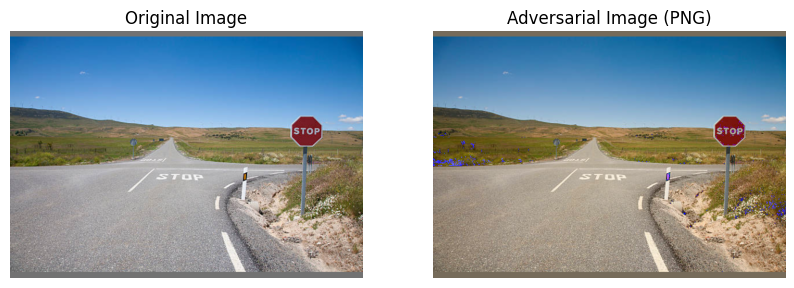

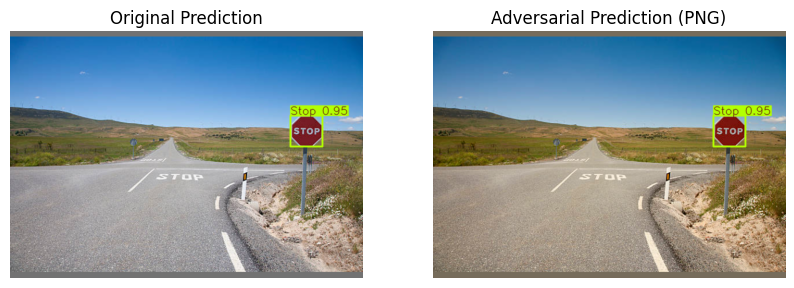

In [52]:
from ultralytics import YOLO
model = YOLO("yolov8n_TrafficSigns.pt")
compare_original_and_adversarial_png(model, "road.jpg", (adv_image),0.5)


In [42]:
model(clean_image)


0: 256x256 (no detections), 131.5ms
Speed: 0.0ms preprocess, 131.5ms inference, 3.6ms postprocess per image at shape (1, 3, 256, 256)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Green Light', 1: 'Red Light', 2: 'Speed Limit 10', 3: 'Speed Limit 100', 4: 'Speed Limit 110', 5: 'Speed Limit 120', 6: 'Speed Limit 20', 7: 'Speed Limit 30', 8: 'Speed Limit 40', 9: 'Speed Limit 50', 10: 'Speed Limit 60', 11: 'Speed Limit 70', 12: 'Speed Limit 80', 13: 'Speed Limit 90', 14: 'Stop'}
 obb: None
 orig_img: array([[[ 0,  0, 71],
         [ 0,  0, 71],
         [ 0,  0, 71],
         ...,
         [ 0,  0, 37],
         [ 0,  0, 35],
         [ 0,  0, 33]],
 
        [[ 0,  0, 73],
         [ 0,  0, 73],
         [ 0,  0, 73],
         ...,
         [ 0,  0, 37],
         [ 0,  0, 35],
         [ 0,  0, 33]],
 
        [[ 0,  0, 73],
         [ 0,  0, 73],
         [ 0,  0, 73],
         ...,
         [ 0,  0, 37],
         [ 0,  0, 35],
         [ 0,  0, 33]],
 
        ...,
 
        [[ 0,  0,  0],
         [ 0,  0,  0],